In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt

sys.path.append("C:/Users/haoyu/Documents/GitHub/XRaySimulation")

from XRaySimulation import Pulse, DeviceSimu, util, Crystal

plt.rcParams.update({'font.size': 22})


In [29]:
# Specify the parameter here
# --------------------------------------------------
# X-ray parameter before the miniSD
Ec = 9.5  # photon central energy in keV
FWHM = 50  # beam transverse size in intensity FWHM (um)
polarization = np.array([1, 0, 0])  # X-ray polarization.  The three entries are respectively y,x,z axis in XPP hutch

# --------------------------------------------------
#  Location of the first grating and the second grating for the original miniSD setup
miniSD_grating_position_1 = 3.01e6  # um
miniSD_grating_position_2 = 3.24e6  # um
miniSD_grating_period = 1.

TG_grating_period = 0.5
TG_grating_position = 1.5e6

# -------------------------------------------------
#  Mirror angle and crystal angle for the TG pump and probe

# -------------------------------------------------
#  Define crystal parameters
h_length = 2. * np.pi / (1.9201 * 1e-4)
# Some crystal properties
crystal_property = {'d': 1.9201 * 1e-4,
                    "chi0": complex(-0.97631E-05, 0.14871E-06),
                    "chih_sigma": complex(0.59310E-05, -0.14320E-06),
                    "chihbar_sigma": complex(0.59310E-05, -0.14320E-06),
                    "chih_pi": complex(0.46945E-05, -0.11201E-06),
                    "chihbar_pi": complex(0.46945E-05, -0.11201E-06),
                    }


def prepare_beam_optics():
    pre_length = 1e6

    # Set up the pulse
    FWHM = 50.  # (um)

    my_pulse = Pulse.GaussianPulse3D()
    my_pulse.set_pulse_properties(central_energy=Ec,
                                  polar=[1., 0., 0.],
                                  sigma_x=FWHM / 2. / np.sqrt(np.log(2)) / util.c,
                                  sigma_y=FWHM / 2. / np.sqrt(np.log(2)) / util.c,
                                  sigma_z=9.,
                                  x0=np.array([0., 0., -pre_length - miniSD_grating_position_1]))

    # ----------------------------------------------------
    # Define gratings for the miniSD
    miniSD_gratings_cc = [Crystal.RectangleGrating(a=miniSD_grating_period / 2.,
                                                   b=miniSD_grating_period / 2.,
                                                   surface_point=np.array([0, 0, -miniSD_grating_position_1]),
                                                   order=-1.),
                          Crystal.RectangleGrating(a=miniSD_grating_period / 2.,
                                                   b=miniSD_grating_period / 2.,
                                                   surface_point=np.array([0, 0, miniSD_grating_position_2]),
                                                   order=1.)]

    miniSD_gratings_vcc = [Crystal.RectangleGrating(a=miniSD_grating_period / 2.,
                                                    b=miniSD_grating_period / 2.,
                                                    surface_point=np.array([0, 0, -miniSD_grating_position_1]),
                                                    order=1.),
                           Crystal.RectangleGrating(a=miniSD_grating_period / 2.,
                                                    b=miniSD_grating_period / 2.,
                                                    surface_point=np.array([0, 0, miniSD_grating_position_2]),
                                                    order=-1.)]

    # -----------------------------------------------------
    # Define grating for the TG
    TG_grating_a = Crystal.RectangleGrating(a=TG_grating_period / 2.,
                                            b=TG_grating_period / 2.,
                                            surface_point=np.array([0, 0, TG_grating_position]),
                                            order=-1.)
    TG_grating_b = Crystal.RectangleGrating(a=TG_grating_period / 2.,
                                            b=TG_grating_period / 2.,
                                            surface_point=np.array([0, 0, TG_grating_position]),
                                            order=1.)

    # -------------------------------------------------------------------------
    #                         VCC branch
    vcc_channel_cut_config = ["lower left", 'upper left', 'upper left', 'lower left']
    vcc_channel_cut_angles = np.deg2rad(np.array([[0, -5], [0, 5], [0, 5], [0, -5]]))
    vcc_channel_cut_locations = [198510.0, 376510.0, 600000.0, 825010.0]

    vcc_channel_cuts = [Crystal.ChannelCut(crystal_type="Silicon",
                                           miller_index="220",
                                           energy_keV=Ec,
                                           thickness_list=np.array([1e4, 1e4]),
                                           gap=13.595e3,
                                           surface_center_offset=32.5,
                                           edge_length_list=np.array([50e3, 65.25e3]),
                                           asymmetry_angle_list=vcc_channel_cut_angles[_x],
                                           first_surface_loc=vcc_channel_cut_config[_x],
                                           source=None,
                                           crystal_property=crystal_property)
                        for _x in range(4)]
    # Change the location of the crystals
    for idx in range(2):
        vcc_channel_cuts[idx].shift(displacement=np.array([0, 0, vcc_channel_cut_locations[idx]]))

    # Align the angle of each crystal
    kout1 = DeviceSimu.get_kout_single_device(device=miniSD_gratings_vcc[0], kin=my_pulse.k0)
    fixed_surface_idx = [0, 1, 1, 0]
    for idx in range(4):
        kout2, _, _, _ = DeviceSimu.align_channel_cut_dynamical_bragg_reflection(channelcut=vcc_channel_cuts[idx],
                                                                                 kin=kout1,
                                                                                 rot_center=
                                                                                 vcc_channel_cuts[idx].crystal_list[
                                                                                     fixed_surface_idx[
                                                                                         idx]].surface_point,
                                                                                 get_curve=True)
        kout1 = np.copy(kout2)

    # -----------------------------------------------------------------------------------
    #                      CC branch
    cc_channel_cut_config = ["upper left", 'lower left', ]
    cc_channel_cut_angles = np.deg2rad(np.array([[0, 0], [0, 0]]))
    cc_channel_cut_locations = [0.0, 1050020.0]
    cc_channel_cut_edge_length_list = np.array([[40e3, 100e3],
                                                [15e3, 120e3]])
    cc_channel_cut_center_offset = [30e3, 52.5e3]
    cc_channel_cut_gap = [25.15e3, 25.8e3]

    cc_channel_cuts = [Crystal.ChannelCut(crystal_type="Silicon",
                                          miller_index="220",
                                          energy_keV=Ec,
                                          thickness_list=np.array([1e4, 1e4]),
                                          gap=cc_channel_cut_gap[_x],
                                          surface_center_offset=cc_channel_cut_center_offset[_x],
                                          edge_length_list=cc_channel_cut_edge_length_list[_x],
                                          asymmetry_angle_list=cc_channel_cut_angles[_x],
                                          first_surface_loc=cc_channel_cut_config[_x],
                                          source=None,
                                          crystal_property=crystal_property)
                       for _x in range(2)]

    # ------------------------------------------------------------------------------------
    # Change location of CC crystals
    for idx in range(2):
        cc_channel_cuts[idx].shift(displacement=np.array([0, 0, cc_channel_cut_locations[idx]]))

    # Align the angle of each crystal
    kout1 = DeviceSimu.get_kout_single_device(device=miniSD_gratings_cc[0], kin=my_pulse.k0)
    fixed_surface_idx = [0, 1]
    for idx in range(2):
        kout2, _, _, _ = DeviceSimu.align_channel_cut_dynamical_bragg_reflection(channelcut=cc_channel_cuts[idx],
                                                                                 kin=kout1,
                                                                                 rot_center=
                                                                                 cc_channel_cuts[idx].crystal_list[
                                                                                     fixed_surface_idx[
                                                                                         idx]].surface_point,
                                                                                 get_curve=True)
        kout1 = np.copy(kout2)

    return my_pulse, miniSD_gratings_cc, miniSD_gratings_vcc, vcc_channel_cuts, cc_channel_cuts, TG_grating_a, TG_grating_b


In [30]:
my_pulse, miniSD_gratings_cc, miniSD_gratings_vcc, vcc_channel_cuts, cc_channel_cuts, TG_grating_a, TG_grating_b = prepare_beam_optics()

The geometric Bragg angle is 19.87 deg
The geometric Bragg angle is 19.87 deg
The geometric Bragg angle is 19.87 deg
The geometric Bragg angle is 19.87 deg
The geometric Bragg angle is 19.87 deg
The geometric Bragg angle is 19.87 deg


In [31]:
for x in range(2):
    for idx in range(2):
        print(cc_channel_cuts[x].crystal_list[idx].surface_point)

[0. 0. 0.]
[     0.         -33850.89899548  19663.14159023]
[       0.         -1070224.9694099    358360.35584909]
[       0.         -1028123.12022891   398972.22967365]


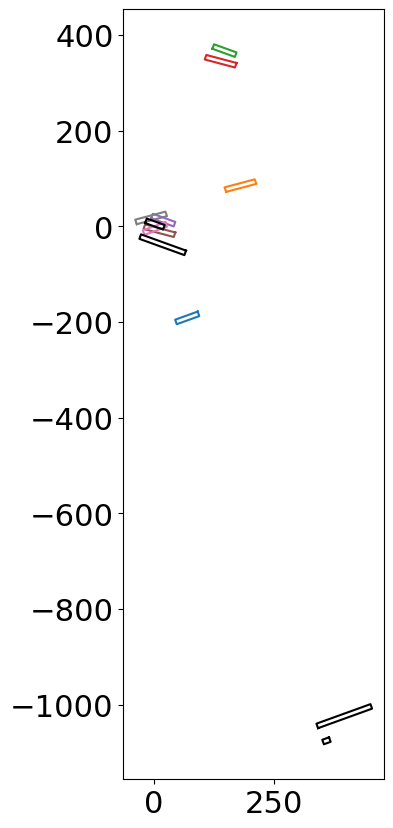

In [32]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

for x in range(4):
    for idx in range(2):
        ax.plot(vcc_channel_cuts[x].crystal_list[idx].boundary[:, 2] / 1000,
                vcc_channel_cuts[x].crystal_list[idx].boundary[:, 1] / 1000,
                )

for x in range(2):
    for idx in range(2):
        ax.plot(cc_channel_cuts[x].crystal_list[idx].boundary[:, 2] / 1000,
                cc_channel_cuts[x].crystal_list[idx].boundary[:, 1] / 1000,
                'k')

ax.set_aspect("equal")
#ax.set_ylim([-200, 200])
#ax.set_xlim([-100, 1200])


plt.show()

# Step 2: Create grating and mirrors for the transient grating